# TabNet Embedding을 통한 학습 개선

딥러닝 모델로 임베딩하여 주관이 들어가는 피처 엔지니어링을 개선하고자 시도하였다. 

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
import torch



In [7]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# fnlwgt열 삭제
train = train.drop(['fnlwgt'], axis=1)
test = test.drop(['fnlwgt'], axis=1)


In [8]:
# train 의 income 0,1 비율
train['income'].value_counts()

0    19077
1     5943
Name: income, dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

for i in train.columns:
    if train[i].dtype == 'object':
        train[i] = label.fit_transform(train[i])
        test[i] = label.fit_transform(test[i])



In [10]:

feature_names = train.columns[:-1]
feature_names

Index(['age', 'workclass', 'education', 'education.num', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'capital.gain',
       'capital.loss', 'hours.per.week', 'native.country'],
      dtype='object')

In [11]:
X  = train.drop('income', axis=1).values
y = train['income'].values


In [12]:
# 데이터 스케일링 (표준화)
X_scaled = X


In [13]:

# TabNet 비지도 학습 모델 정의
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax'  # 'sparsemax' 또는 'entmax' 선택 가능
)
# 비지도 학습 수행
unsupervised_model.fit(
    X_train=X_scaled,
    max_epochs=100,  # 최대 학습 횟수
    patience=10,  # 조기 종료를 위한 patience 설정
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8
)


/opt/homebrew/Caskroom/miniforge/base/envs/sundo/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/homebrew/Caskroom/miniforge/base/envs/sundo/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 6.32248 |  0:00:00s
epoch 1  | loss: 2.61174 |  0:00:01s
epoch 2  | loss: 1.13162 |  0:00:01s
epoch 3  | loss: 1.02575 |  0:00:02s
epoch 4  | loss: 1.00162 |  0:00:02s
epoch 5  | loss: 1.00219 |  0:00:02s
epoch 6  | loss: 1.00363 |  0:00:03s
epoch 7  | loss: 0.99405 |  0:00:04s
epoch 8  | loss: 1.00091 |  0:00:04s
epoch 9  | loss: 0.99083 |  0:00:05s
epoch 10 | loss: 0.99581 |  0:00:05s
epoch 11 | loss: 0.9871  |  0:00:06s
epoch 12 | loss: 0.99026 |  0:00:06s
epoch 13 | loss: 0.98854 |  0:00:07s
epoch 14 | loss: 0.98881 |  0:00:07s
epoch 15 | loss: 0.98022 |  0:00:08s
epoch 16 | loss: 0.976   |  0:00:08s
epoch 17 | loss: 0.98119 |  0:00:08s
epoch 18 | loss: 0.97815 |  0:00:09s
epoch 19 | loss: 0.9724  |  0:00:09s
epoch 20 | loss: 0.97978 |  0:00:10s
epoch 21 | loss: 0.97082 |  0:00:10s
epoch 22 | loss: 0.97438 |  0:00:10s
epoch 23 | loss: 0.97225 |  0:00:11s
epoch 24 | loss: 0.96751 |  0:00:11s
epoch 25 | loss: 0.96534 |  0:00:12s
epoch 26 | loss: 0.96286 |  0:00:12s
e

In [14]:
# TabNet 임베딩 추출
# 학습된 TabNet 모델에서 임베딩을 추출하여 클러스터링에 사용
embeddings = unsupervised_model.network.forward(torch.Tensor(X_scaled))[0].detach().numpy()
embeddings.shape


(25020, 13)

In [15]:
X_test = test.drop('income', axis=1).values
y_test = test['income'].values

In [16]:
# X_test 임베딩 추출
embeddings_test = unsupervised_model.network.forward(torch.Tensor(X_test))[0].detach().numpy()

In [17]:
embeddings_test

array([[ 42.76725  ,   3.0763755,   8.149796 , ..., 102.58901  ,
         42.860966 ,  37.219936 ],
       [ 30.866907 ,   3.467807 ,  11.134852 , ...,  67.282    ,
         38.440773 ,  36.393482 ],
       [ 38.918266 ,   2.7836714,  10.189702 , ...,  81.56195  ,
         38.0727   ,  36.537758 ],
       ...,
       [ 40.143547 ,   3.5574849,  13.889455 , ...,  98.8775   ,
         43.15571  ,  36.787777 ],
       [ 37.10283  ,   3.6944327,  13.297396 , ...,  67.78739  ,
         39.167553 ,  36.477707 ],
       [ 30.866907 ,   3.467807 ,  11.134852 , ...,  67.282    ,
         38.440773 ,  36.393482 ]], dtype=float32)

In [18]:
# embedding한 거로 lightgbm 

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score


lgbm = LGBMClassifier(n_estimators=2000, learning_rate=0.005)
lgbm.fit(X, y)

y_pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

/opt/homebrew/Caskroom/miniforge/base/envs/sundo/lib/python3.10/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/homebrew/Caskroom/miniforge/base/envs/sundo/lib/python3.10/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/homebrew/Caskroom/miniforge/base/envs/sundo/lib/python3.10/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd

[LightGBM] [Info] Number of positive: 5943, number of negative: 19077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 25020, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237530 -> initscore=-1.166269
[LightGBM] [Info] Start training from score -1.166269
0.8704415859965522


In [19]:
# 예측이 틀린 열만 출력
test['pred'] = y_pred
test[test['income'] != test['pred']]

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,pred
3,35,2,14,15,4,9,1,1,1,0,0,40,17,1,0
5,51,1,11,9,2,2,0,4,1,0,0,40,36,1,0
9,22,2,11,9,2,13,0,4,1,0,0,50,36,1,0
10,52,2,15,10,2,11,0,4,1,0,0,40,36,0,1
12,32,2,9,13,4,9,1,4,1,0,0,40,36,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,35,2,12,14,4,9,1,4,1,0,0,45,36,1,0
7503,32,5,11,9,2,13,0,4,1,0,0,40,36,1,0
7509,36,0,9,13,2,3,5,4,0,0,0,40,36,0,1
7520,60,4,11,9,0,2,1,4,1,0,0,50,36,1,0


In [20]:
# 틀린 행 번호 리스트
wrong_idx = test[test['income'] != test['pred']].index.tolist()
wrong_idx

[3,
 5,
 9,
 10,
 12,
 13,
 48,
 57,
 65,
 73,
 88,
 97,
 105,
 130,
 136,
 145,
 152,
 154,
 160,
 162,
 167,
 182,
 194,
 209,
 211,
 213,
 217,
 218,
 222,
 227,
 230,
 249,
 250,
 268,
 271,
 273,
 279,
 287,
 291,
 293,
 304,
 309,
 314,
 317,
 355,
 359,
 362,
 363,
 369,
 370,
 372,
 373,
 376,
 416,
 426,
 427,
 431,
 444,
 455,
 470,
 484,
 492,
 495,
 497,
 503,
 506,
 513,
 514,
 521,
 525,
 530,
 532,
 534,
 540,
 554,
 557,
 558,
 563,
 573,
 582,
 595,
 609,
 614,
 620,
 623,
 631,
 634,
 644,
 646,
 657,
 667,
 678,
 684,
 696,
 703,
 709,
 723,
 734,
 744,
 747,
 756,
 762,
 763,
 766,
 767,
 780,
 802,
 832,
 846,
 858,
 877,
 884,
 891,
 893,
 894,
 899,
 904,
 905,
 913,
 920,
 922,
 932,
 944,
 952,
 956,
 959,
 961,
 964,
 978,
 983,
 992,
 995,
 997,
 1008,
 1010,
 1012,
 1013,
 1015,
 1019,
 1031,
 1040,
 1043,
 1050,
 1065,
 1074,
 1076,
 1092,
 1100,
 1101,
 1108,
 1113,
 1126,
 1127,
 1151,
 1159,
 1166,
 1173,
 1174,
 1180,
 1184,
 1209,
 1226,
 1228,
 1241,


In [21]:
# 코사인 유사도를 이용한 클러스터링
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 계산
cosine_sim = cosine_similarity(embeddings, embeddings_test)
cosine_sim


array([[0.9998617 , 0.9996262 , 0.9998177 , ..., 0.99982566, 0.999585  ,
        0.9996262 ],
       [0.99858576, 0.9997397 , 0.99976844, ..., 0.99862427, 0.9997112 ,
        0.9997397 ],
       [0.99858576, 0.9997397 , 0.99976844, ..., 0.99862427, 0.9997112 ,
        0.9997397 ],
       ...,
       [0.9993833 , 0.9976227 , 0.99780786, ..., 0.99935156, 0.99762434,
        0.9976227 ],
       [0.9988401 , 0.99982077, 0.9998636 , ..., 0.9988819 , 0.9997964 ,
        0.99982077],
       [0.9999025 , 0.9989034 , 0.9990141 , ..., 0.9998945 , 0.99888206,
        0.9989034 ]], dtype=float32)

In [22]:
# cosine_sim to dataframe
cosine_sim_df = pd.DataFrame(cosine_sim, columns=test.index)
cosine_sim_df

,0,1,2,3,4,5,6,7,8,9,...,7531,7532,7533,7534,7535,7536,7537,7538,7539,7540
0,0.999862,0.999626,0.999818,0.999873,0.999306,0.999631,0.999669,0.999492,0.998985,0.999631,...,0.998837,0.999885,0.998938,0.999590,0.998778,0.998255,0.999631,0.999826,0.999585,0.999626
1,0.998586,0.999740,0.999768,0.998982,0.997081,0.997862,0.999877,0.999958,0.996454,0.997862,...,0.996183,0.999309,0.999854,0.997777,0.999947,0.999822,0.997862,0.998624,0.999711,0.999740
2,0.998586,0.999740,0.999768,0.998982,0.997081,0.997862,0.999877,0.999958,0.996454,0.997862,...,0.996183,0.999309,0.999854,0.997777,0.999947,0.999822,0.997862,0.998624,0.999711,0.999740
3,0.999960,0.999441,0.999479,0.999957,0.999666,0.999894,0.999291,0.999040,0.999455,0.999894,...,0.999352,0.999867,0.998617,0.999878,0.998196,0.997555,0.999894,1.000000,0.999452,0.999441
4,0.999946,0.999210,0.999361,0.999816,0.999713,0.999854,0.999079,0.998829,0.999483,0.999854,...,0.999372,0.999707,0.998224,0.999835,0.997846,0.997198,0.999854,0.999834,0.999146,0.999210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25015,0.999363,0.999884,0.999991,0.999576,0.998273,0.998846,0.999980,0.999946,0.997779,0.998846,...,0.997562,0.999774,0.999647,0.998788,0.999627,0.999330,0.998846,0.999361,0.999870,0.999884
25016,0.999363,0.999884,0.999991,0.999576,0.998273,0.998846,0.999980,0.999946,0.997779,0.998846,...,0.997562,0.999774,0.999647,0.998788,0.999627,0.999330,0.998846,0.999361,0.999870,0.999884
25017,0.999383,0.997623,0.997808,0.999036,0.999933,0.999752,0.997386,0.996908,0.999995,0.999752,...,1.000000,0.998664,0.996086,0.999778,0.995437,0.994448,0.999752,0.999352,0.997624,0.997623
25018,0.998840,0.999821,0.999864,0.999192,0.997462,0.998188,0.999947,0.999991,0.996877,0.998188,...,0.996624,0.999480,0.999837,0.998107,0.999894,0.999713,0.998188,0.998882,0.999796,0.999821


In [23]:
# 열이 wrong_idx인 행만 추출
cosine_sim_df_wrong = cosine_sim_df[wrong_idx]
cosine_sim_df_wrong

,3,5,9,10,12,13,48,57,65,73,...,7461,7466,7471,7478,7479,7500,7503,7509,7520,7526
0,0.999873,0.999631,0.999631,0.999826,0.999865,0.999458,0.999631,0.999826,0.999183,0.999458,...,0.998837,0.999768,0.999631,0.999306,0.999603,0.999885,0.999631,1.000000,0.999910,0.999458
1,0.998982,0.997862,0.997862,0.998624,0.999391,0.997433,0.997862,0.998624,1.000000,0.997433,...,0.996183,0.999692,0.997862,0.997081,0.997751,0.999183,0.997862,0.999183,0.998915,0.997433
2,0.998982,0.997862,0.997862,0.998624,0.999391,0.997433,0.997862,0.998624,1.000000,0.997433,...,0.996183,0.999692,0.997862,0.997081,0.997751,0.999183,0.997862,0.999183,0.998915,0.997433
3,0.999957,0.999894,0.999894,1.000000,0.999804,0.999726,0.999894,1.000000,0.998624,0.999726,...,0.999352,0.999302,0.999894,0.999666,0.999845,0.999903,0.999894,0.999826,0.999976,0.999726
4,0.999816,0.999854,0.999854,0.999834,0.999681,0.999851,0.999854,0.999834,0.998410,0.999851,...,0.999372,0.999392,0.999854,0.999713,0.999883,0.999770,0.999854,0.999811,0.999860,0.999851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25015,0.999576,0.998846,0.998846,0.999361,0.999803,0.998545,0.998846,0.999361,0.999837,0.998545,...,0.997562,0.999932,0.998846,0.998273,0.998778,0.999695,0.998846,0.999742,0.999560,0.998545
25016,0.999576,0.998846,0.998846,0.999361,0.999803,0.998545,0.998846,0.999361,0.999837,0.998545,...,0.997562,0.999932,0.998846,0.998273,0.998778,0.999695,0.998846,0.999742,0.999560,0.998545
25017,0.999036,0.999752,0.999752,0.999352,0.998512,0.999820,0.999752,0.999352,0.996183,0.999820,...,1.000000,0.997660,0.999752,0.999933,0.999779,0.998814,0.999752,0.998837,0.999144,0.999820
25018,0.999192,0.998188,0.998188,0.998882,0.999543,0.997779,0.998188,0.998882,0.999984,0.997779,...,0.996624,0.999775,0.998188,0.997462,0.998082,0.999367,0.998188,0.999377,0.999140,0.997779


In [24]:
# 3번 열과 가장 유사한 행을 찾아보자
cosine_sim_df_wrong.idxmax(axis=0)


3       207
5         5
9         5
10        3
12        9
       ... 
7500    360
7503      5
7509      0
7520    163
7526     71
Length: 977, dtype: int64

In [25]:
# cosine_sim_df_wrong.idxmax(axis=0) 원소 개수 확인
cosine_sim_df_wrong.idxmax(axis=0).value_counts()

5        212
3        170
13       168
62        44
6         34
        ... 
1117       1
23033      1
583        1
3019       1
3634       1
Length: 89, dtype: int64

In [26]:
# train의 207번 행
train.loc[207]

age               27
workclass          6
education         14
education.num     15
marital.status     4
occupation         9
relationship       1
race               4
sex                1
capital.gain       0
capital.loss       0
hours.per.week    70
native.country    38
income             0
Name: 207, dtype: int64

In [27]:
# test의 3번 행 
test.loc[3]

age               35
workclass          2
education         14
education.num     15
marital.status     4
occupation         9
relationship       1
race               1
sex                1
capital.gain       0
capital.loss       0
hours.per.week    40
native.country    17
income             1
pred               0
Name: 3, dtype: int64

In [28]:
# train과 test 5번 행
train.loc[13156]


age               51
workclass          3
education          9
education.num     13
marital.status     2
occupation        11
relationship       0
race               4
sex                1
capital.gain       0
capital.loss       0
hours.per.week    40
native.country    38
income             1
Name: 13156, dtype: int64

In [29]:
# train과 test 유사한 행 출력(전체 데이터), 모든 행
cosine_sim_df.idxmax(axis=0)

0       339
1        10
2       417
3       207
4        13
       ... 
7536     27
7537      5
7538      3
7539    226
7540     10
Length: 7541, dtype: int64

In [30]:
train

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,41,3,9,13,0,3,4,4,0,0,0,45,38,0
1,20,3,11,9,4,7,3,4,0,0,0,40,25,0
2,73,3,11,9,6,7,1,4,0,0,0,37,38,0
3,56,4,15,10,2,3,0,4,1,7688,0,50,38,1
4,53,3,1,7,2,6,0,4,1,0,0,40,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25015,35,8,9,13,2,14,5,4,0,0,0,55,38,1
25016,30,8,9,13,4,14,1,1,0,0,0,99,38,0
25017,71,8,10,16,2,14,0,4,1,0,0,10,38,1
25018,41,8,11,9,5,14,1,2,0,0,0,32,38,0


In [31]:
cosine_sim_df.idxmax(axis=0).values

array([339,  10, 417, ...,   3, 226,  10])

In [32]:
train

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,41,3,9,13,0,3,4,4,0,0,0,45,38,0
1,20,3,11,9,4,7,3,4,0,0,0,40,25,0
2,73,3,11,9,6,7,1,4,0,0,0,37,38,0
3,56,4,15,10,2,3,0,4,1,7688,0,50,38,1
4,53,3,1,7,2,6,0,4,1,0,0,40,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25015,35,8,9,13,2,14,5,4,0,0,0,55,38,1
25016,30,8,9,13,4,14,1,1,0,0,0,99,38,0
25017,71,8,10,16,2,14,0,4,1,0,0,10,38,1
25018,41,8,11,9,5,14,1,2,0,0,0,32,38,0


In [33]:
train.value_counts('income')

income
0    19077
1     5943
dtype: int64

In [34]:
train.loc[207]

age               27
workclass          6
education         14
education.num     15
marital.status     4
occupation         9
relationship       1
race               4
sex                1
capital.gain       0
capital.loss       0
hours.per.week    70
native.country    38
income             0
Name: 207, dtype: int64

In [69]:
#PCA (2차원으로 축소 후 클러스터링)
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(embeddings)
pca_embeddings = pca.transform(embeddings)
pca_embeddings.shape


(25020, 3)

In [89]:
# test_embedding도 pca 적용
pca_embeddings_test = pca.transform(embeddings_test)
pca_embeddings_test.shape


(7541, 3)

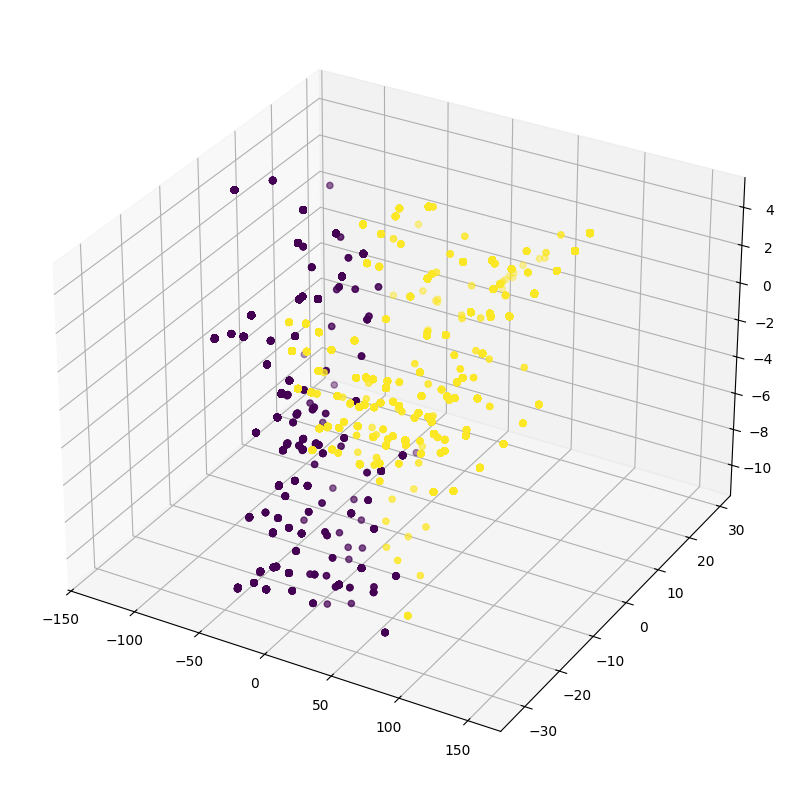

In [88]:
# GMM 3d 클러스터링

from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(pca_embeddings)
cluster = gmm.predict(pca_embeddings)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], pca_embeddings[:, 2], c=cluster)



# 3d 파일 ./data에 저장 
plt.savefig('./data/3d.png')





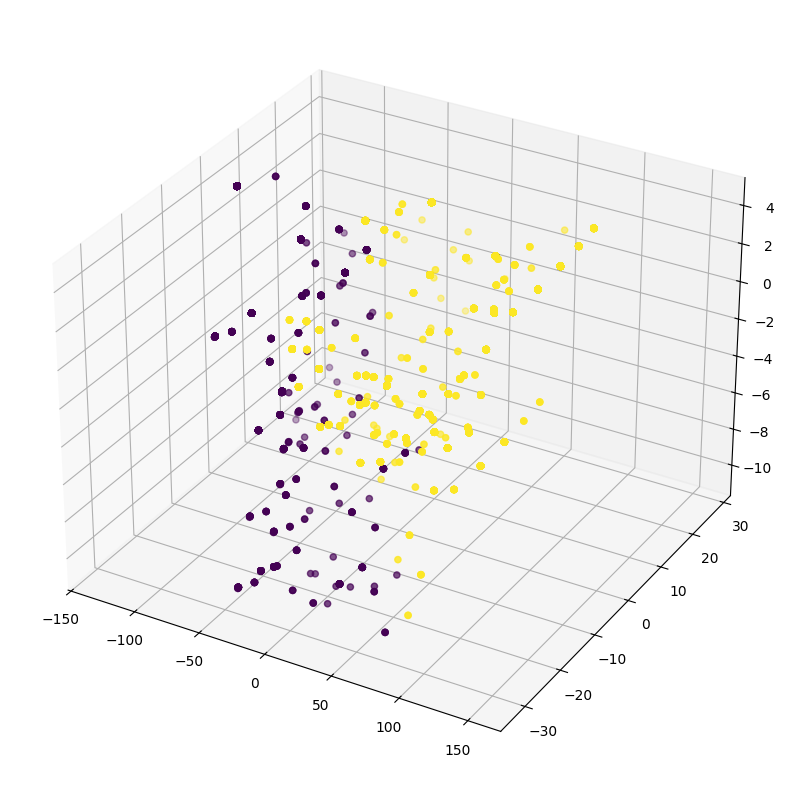

In [91]:
# pca_embeddings_test 클러스터링
cluster_test = gmm.predict(pca_embeddings_test)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_embeddings_test[:, 0], pca_embeddings_test[:, 1], pca_embeddings_test[:, 2], c=cluster_test)

# 3d 파일 ./data에 저장
plt.savefig('./data/3d_test.png')

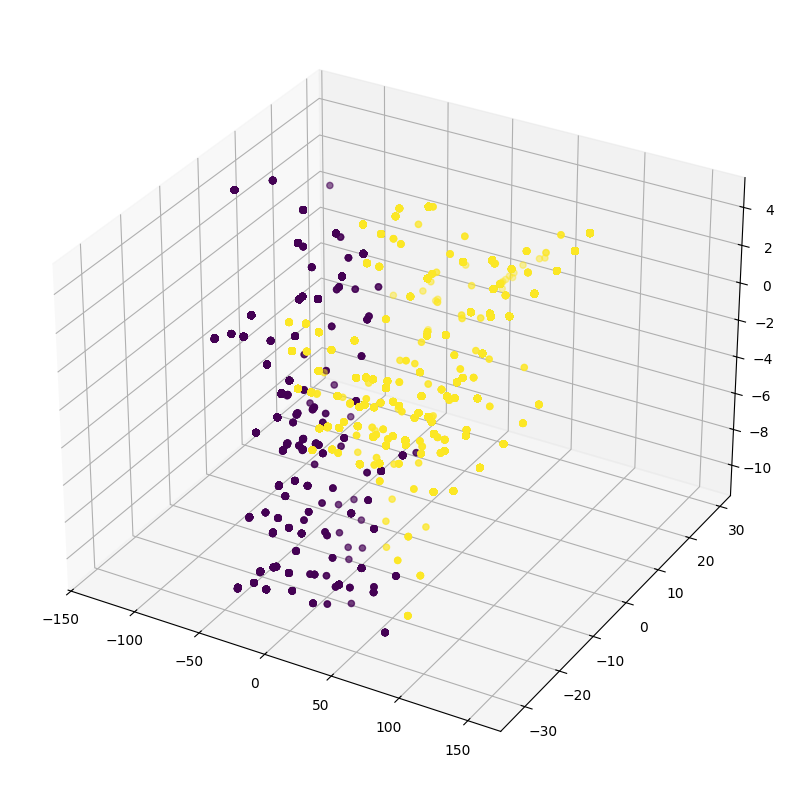

In [92]:
#  pca_embeddings_test의 클러스터들, , pca_embeddings의 클러스터들 색 각각 다르게 해서 그래프 그리기
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], pca_embeddings[:, 2], c=cluster)
ax.scatter(pca_embeddings_test[:, 0], pca_embeddings_test[:, 1], pca_embeddings_test[:, 2], c=cluster_test)

# 3d 파일 ./data에 저장
plt.savefig('./data/3d_both.png')


In [98]:
# 각 클러스터의 값들 비교
cluster_0 = train[cluster == 0]
cluster_1 = train[cluster == 1]

cluster_0.value_counts('income')


income
0    7557
1     339
dtype: int64

In [99]:
cluster_1.value_counts('income')


income
0    11520
1     5604
dtype: int64

In [100]:
# test 데이터의 클러스터 0, 1 비율
test['cluster'] = cluster_test
test_cluster_0 = test[test['cluster'] == 0]
test_cluster_1 = test[test['cluster'] == 1]

test_cluster_0.value_counts('income')


income
0    2159
1     112
dtype: int64

In [101]:
test_cluster_1.value_counts('income')


income
0    3484
1    1786
dtype: int64

In [102]:
# 클러스터의 행 번호
cluster_0_index = cluster_0.index.tolist()
cluster_1_index = cluster_1.index.tolist()


In [103]:
# test
test_cluster_0_index = test_cluster_0.index.tolist()
test_cluster_1_index = test_cluster_1.index.tolist()

In [106]:
test.drop(['pred', 'cluster'], axis=1, inplace=True)

KeyError: "['cluster'] not found in axis"

In [109]:
# cluster_0_index에 해당하는 train 데이터 lgbm 모델로 학습
X = train.loc[cluster_0_index].drop('income', axis=1).values
y = train.loc[cluster_0_index]['income'].values

lgbm = LGBMClassifier(n_estimators=2000, learning_rate=0.005)
lgbm.fit(X, y)

# cluster_0_index에 해당하는 test 데이터로 예측
X_test = test.loc[test_cluster_0_index].drop('income', axis=1).values
y_test = test.loc[test_cluster_0_index]['income'].values

y_pred_0 = lgbm.predict(X_test)
accuracy_0 = accuracy_score(y_test, y_pred_0)
print(accuracy)

[LightGBM] [Info] Number of positive: 339, number of negative: 7557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 7896, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042933 -> initscore=-3.104229
[LightGBM] [Info] Start training from score -3.104229
0.8265654648956356


In [118]:
# cluster_1_index에 해당하는 train 데이터 lgbm 모델로 학습
X = train.loc[cluster_1_index].drop('income', axis=1).values
y = train.loc[cluster_1_index]['income'].values

lgbm = LGBMClassifier(n_estimators=1000, learning_rate=0.005)
lgbm.fit(X, y)

# cluster_1_index에 해당하는 test 데이터로 예측
X_test = test.loc[test_cluster_1_index].drop('income', axis=1).values
y_test = test.loc[test_cluster_1_index]['income'].values

y_pred_1 = lgbm.predict(X_test)
accuracy_1= accuracy_score(y_test, y_pred_1)
print(accuracy_1)

[LightGBM] [Info] Number of positive: 5604, number of negative: 11520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 17124, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327260 -> initscore=-0.720604
[LightGBM] [Info] Start training from score -0.720604
0.8263757115749526


In [93]:
# TabNet Spuervised 학습
# TabNet 모델 정의

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax'  # This will be overwritten if using pretrain model
)

# TabNet 학습

clf.fit(
    X_train=X, y_train=y,
    eval_set=[(X, y), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100, patience=15,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)


/opt/homebrew/Caskroom/miniforge/base/envs/sundo/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61408 | train_accuracy: 0.4241  | valid_accuracy: 0.40207 |  0:00:00s
epoch 1  | loss: 0.47362 | train_accuracy: 0.56771 | valid_accuracy: 0.5425  |  0:00:01s
epoch 2  | loss: 0.44363 | train_accuracy: 0.36495 | valid_accuracy: 0.37144 |  0:00:01s
epoch 3  | loss: 0.43942 | train_accuracy: 0.47014 | valid_accuracy: 0.47023 |  0:00:02s
epoch 4  | loss: 0.42696 | train_accuracy: 0.66223 | valid_accuracy: 0.65721 |  0:00:03s
epoch 5  | loss: 0.41318 | train_accuracy: 0.71567 | valid_accuracy: 0.7068  |  0:00:03s
epoch 6  | loss: 0.40724 | train_accuracy: 0.70144 | valid_accuracy: 0.69885 |  0:00:04s
epoch 7  | loss: 0.40516 | train_accuracy: 0.73137 | valid_accuracy: 0.71529 |  0:00:04s
epoch 8  | loss: 0.39734 | train_accuracy: 0.75316 | valid_accuracy: 0.73107 |  0:00:05s
epoch 9  | loss: 0.39402 | train_accuracy: 0.77094 | valid_accuracy: 0.75587 |  0:00:06s
epoch 10 | loss: 0.38466 | train_accuracy: 0.76551 | valid_accuracy: 0.7491  |  0:00:06s
epoch 11 | loss: 0.39

/opt/homebrew/Caskroom/miniforge/base/envs/sundo/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


클러스터 0에는 0인 특성들이 많이 포함됨 

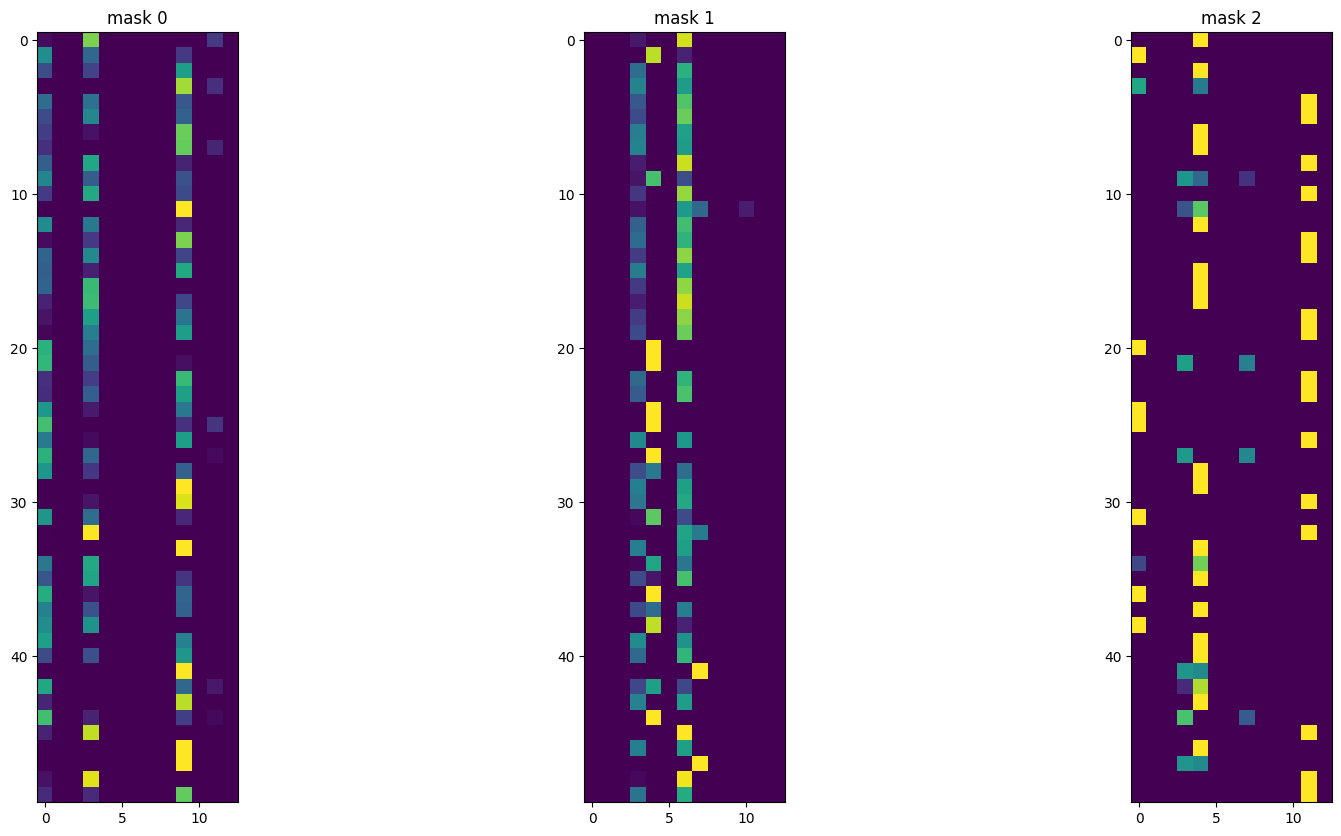

In [94]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,10))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# 이미지 저장
plt.savefig('./data/mask.png')